In [1]:
import pandas as pd
import numpy as np
import collections as c
from sklearn.utils import shuffle
from itertools import cycle
from scipy import interp
import csv
from time import time

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set(style="whitegrid", palette="deep")
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve, validation_curve, cross_val_score, cross_val_predict

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

In [2]:
reg_season = pd.read_csv('data/RegularSeasonDetailedResults.csv')
seasons = pd.read_csv('data/Seasons.csv', index_col = 'Season')
teams = pd.read_csv('data/Teams.csv')#, index_col = 'Team_Id')
tourney = pd.read_csv('data/TourneyDetailedResults.csv')
seeds = pd.read_csv('data/TourneySeeds.csv')
slots = pd.read_csv('data/TourneySlots.csv')
submission = pd.read_csv('data/SampleSubmission2016.csv')
elo_table = pd.read_csv('data/elo_table.csv')

Bring in data from table created from scrape of sports-reference.com website.

In [3]:
stats = pd.read_csv('data/stats_df.csv')
cols = ['school', 'season', 'sos', 'srs']

#sos - strength of schedule
#srs - simple rating system

team_stats = stats[cols]

In [4]:
reg_season.head()

,Season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lfga3,Lftm,Lfta,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [5]:
#remove NCAA from end of school names in team_stats data frame
def isNCAA(row):
    if row['school'][-4:] == 'NCAA':
        return row['school'][:-5]
    else:
        return row['school']

In [6]:
team_stats['School'] = None
team_stats['School'] = team_stats.apply(lambda row: isNCAA(row), axis=1)

In [7]:
team_stats.drop(['school'], axis=1, inplace=True)
team_stats.rename(columns={'School': 'school'}, inplace=True)

In [8]:
team_stats.head()

,season,sos,srs,school
0,1996,5.04,-5.63,Air Force
1,1996,2.51,-11.17,Akron
2,1996,3.70,3.66,Alabama-Birmingham
3,1996,-12.77,-23.56,Alabama State
4,1996,6.13,7.00,Alabama


In [9]:
#function to make unique row id
def make_id(row):
    return str(row['Season']) + '_' + str(row['Wteam']) + '_' + str(row['Lteam']) + '_' + str(row['Daynum'])

In [10]:
reg_season['game_id'] = None
reg_season['game_id'] = reg_season.apply(lambda row: make_id(row),axis=1)

In [11]:
season_df = reg_season.copy()

In [12]:
#rename columns, winning team becomes team A, losing team becomes team B
col_names = ['season', 'daynum', 'team_A', 'teamA_score', 'team_B', 'teamB_score', 'teamA_loc', 'num_OTs', 
               'teamA_fgm', 'teamA_fga', 'teamA_3ptm', 'teamA_3pta', 'teamA_ftm', 'teamA_fta', 'teamA_offreb',
               'teamA_defreb', 'teamA_asts', 'teamA_turn_ovs', 'teamA_stls', 'teamA_blks', 'teamA_fouls', 
               'teamB_fgm', 'teamB_fga', 'teamB_3ptm', 'teamB_3pta', 'teamB_ftm', 'teamB_fta', 'teamB_offreb',
               'teamB_defreb', 'teamB_asts', 'teamB_turn_ovs', 'teamB_stls', 'teamB_blks', 'teamB_fouls', 'game_id']

season_df.columns = col_names

In [13]:
#shuffle data set to randomize seasons and games
season_df = shuffle(season_df)

In [14]:
season_df.shape

(76636, 35)

In [15]:
#split data set in half, in order to set half of games to wins and half to losses
season_df_1 = season_df[:int((season_df.shape[0]/2))]
season_df_2 = season_df[int((season_df.shape[0]/2)):]

In [16]:
#rename columns of second data frame 
season_df_2.rename(columns={'team_A': 'team_B', 'teamA_score': 'teamB_score', 'team_B': 'team_A',
                             'teamB_score': 'teamA_score', 'teamA_loc': 'teamB_loc', 'teamA_fgm': 'teamB_fgm',
                             'teamA_fga': 'teamB_fga', 'teamA_3ptm': 'teamB_3ptm', 'teamA_3pta': 'teamB_3pta',
                             'teamA_ftm': 'teamB_ftm', 'teamA_fta': 'teamB_fta', 'teamA_offreb': 'teamB_offreb',
                             'teamA_defreb': 'teamB_defreb', 'teamA_asts': 'teamB_asts', 
                             'teamA_turn_ovs': 'teamB_turn_ovs', 'teamA_stls': 'teamB_stls', 'teamA_blks': 'teamB_blks',
                             'teamA_fouls': 'teamB_fouls', 'teamB_fgm': 'teamA_fgm',
                             'teamB_fga': 'teamA_fga', 'teamB_3ptm': 'teamA_3ptm', 'teamB_3pta': 'teamA_3pta',
                             'teamB_ftm': 'teamA_ftm', 'teamB_fta': 'teamA_fta', 'teamB_offreb': 'teamA_offreb',
                             'teamB_defreb': 'teamA_defreb', 'teamB_asts': 'teamA_asts', 
                             'teamB_turn_ovs': 'teamA_turn_ovs', 'teamB_stls': 'teamA_stls', 'teamB_blks': 'teamA_blks',
                             'teamB_fouls': 'teamA_fouls'}, inplace=True)

In [17]:
def change_loc(row):
    if row['teamB_loc'] == 'A':
        return 'H'
    elif row['teamB_loc'] == 'H':
        return 'A'
    else:
        return 'N'

In [18]:
season_df_1['teamA_win'] = 1
season_df_2['teamA_win'] = 0

In [19]:
#concat data frames back together
season_new_df = pd.concat((season_df_1, season_df_2))
season_new_df = shuffle(season_new_df)

In [20]:
season_new_df['teamA_3ptper'] = season_new_df['teamA_3ptm'] / season_new_df['teamA_3pta']
season_new_df['teamA_fgper'] = season_new_df['teamA_fgm'] / season_new_df['teamA_fga']
season_new_df['teamA_ftper'] = season_new_df['teamA_ftm'] / season_new_df['teamA_fta']

season_new_df['teamB_3ptper'] = season_new_df['teamB_3ptm'] / season_new_df['teamB_3pta']
season_new_df['teamB_fgper'] = season_new_df['teamB_fgm'] / season_new_df['teamB_fga']
season_new_df['teamB_ftper'] = season_new_df['teamB_ftm'] / season_new_df['teamB_fta']

In [21]:
#calculate difference of stats between teamA and teamB
season_new_df['3ptper_diff'] = season_new_df['teamA_3ptper'] - season_new_df['teamB_3ptper']
season_new_df['fgper_diff'] = season_new_df['teamA_fgper'] - season_new_df['teamB_fgper']
season_new_df['ftper_diff'] = season_new_df['teamA_ftper'] - season_new_df['teamB_ftper']

season_new_df['asts_diff'] = season_new_df['teamA_asts'] - season_new_df['teamB_asts']
season_new_df['stls_diff'] = season_new_df['teamA_stls'] - season_new_df['teamB_stls']
season_new_df['blks_diff'] = season_new_df['teamA_blks'] - season_new_df['teamB_blks']

season_new_df['turn_ovs_diff'] = season_new_df['teamA_turn_ovs'] - season_new_df['teamB_turn_ovs']
season_new_df['offreb_diff'] = season_new_df['teamA_offreb'] - season_new_df['teamB_offreb']
season_new_df['defreb_diff'] = season_new_df['teamA_defreb'] - season_new_df['teamB_defreb']
season_new_df['fouls_diff'] = season_new_df['teamA_fouls'] - season_new_df['teamB_fouls']

In [75]:
#combine team_stats with teams data frame
team_stats_df = pd.merge(left=team_stats, right=teams, left_on='school', right_on='Team_Name')

In [76]:
team_stats_df.head()

,season,sos,srs,school,Team_Id,Team_Name
0,1996,5.04,-5.63,Air Force,1102,Air Force
1,1997,1.15,-4.94,Air Force,1102,Air Force
2,1998,2.59,-5.51,Air Force,1102,Air Force
3,1999,2.53,-4.00,Air Force,1102,Air Force
4,2000,2.58,-5.07,Air Force,1102,Air Force


In [24]:
#bring in sos and srs data for team A
season_new_df = pd.merge(left=season_new_df, right=team_stats_df[['season', 'Team_Id', 'sos', 'srs']], 
                         left_on=['season', 'team_A'], right_on=['season', 'Team_Id'], how='outer')

season_new_df = season_new_df.drop(['Team_Id'], axis=1)
season_new_df.rename(columns={'sos': 'teamA_sos', 'srs': 'teamA_srs'}, inplace=True)

In [25]:
#bring in sos and srs data for team B
season_new_df = pd.merge(left=season_new_df, right=team_stats_df[['season', 'Team_Id', 'sos', 'srs']], 
                         left_on=['season', 'team_B'], right_on=['season', 'Team_Id'], how='outer')

season_new_df = season_new_df.drop(['Team_Id'], axis=1)
season_new_df.rename(columns={'sos': 'teamB_sos', 'srs': 'teamB_srs'}, inplace=True)

In [26]:
#bring in elo data for team A
season_new_df = pd.merge(left=season_new_df, right=elo_table[['season', 'Team_Id', 'elo']],
                         left_on=['season', 'team_A'], right_on=['season', 'Team_Id'], how='outer')
season_new_df.drop(['Team_Id'], axis=1, inplace=True)
season_new_df.rename(columns={'elo': 'teamA_elo'}, inplace=True)

In [27]:
#bring in elo data for team B
season_new_df = pd.merge(left=season_new_df, right=elo_table[['season', 'Team_Id', 'elo']],
                         left_on=['season', 'team_B'], right_on=['season', 'Team_Id'], how='outer')
season_new_df.drop(['Team_Id'], axis=1, inplace=True)
season_new_df.rename(columns={'elo': 'teamB_elo'}, inplace=True)

In [28]:
season_new_df = season_new_df.replace(np.nan, 0)

In [29]:
season_new_df.head()

,daynum,game_id,num_OTs,season,teamA_3pta,teamA_3ptm,teamA_asts,teamA_blks,teamA_defreb,teamA_fga,...,turn_ovs_diff,offreb_diff,defreb_diff,fouls_diff,teamA_sos,teamA_srs,teamB_sos,teamB_srs,teamA_elo,teamB_elo
0,97.0,2009_1340_1170_97,0.0,2009,9.0,1.0,6.0,0.0,25.0,48.0,...,1.0,-5.0,-3.0,3.0,0.00,0.00,0.0,0.0,891.0,1411.0
1,50.0,2009_1340_1211_50,0.0,2009,19.0,7.0,13.0,4.0,22.0,56.0,...,-2.0,-5.0,-4.0,-4.0,3.55,17.95,0.0,0.0,1663.0,1411.0
2,25.0,2009_1214_1340_25,1.0,2009,10.0,4.0,18.0,7.0,27.0,50.0,...,-1.0,-10.0,12.0,-8.0,-7.58,-10.79,0.0,0.0,1170.0,1411.0
3,117.0,2009_1340_1186_117,1.0,2009,14.0,5.0,17.0,5.0,20.0,57.0,...,0.0,-4.0,-3.0,6.0,0.00,0.00,0.0,0.0,1143.0,1411.0
4,23.0,2009_1340_1296_23,0.0,2009,15.0,4.0,11.0,5.0,26.0,56.0,...,9.0,-3.0,0.0,-3.0,0.00,0.00,0.0,0.0,1082.0,1411.0


In [30]:
def create_elo_diff(row):
    if row['teamA_elo'] == 0 or row['teamB_elo'] == 0:
        return 0
    else:
        return row['teamA_elo'] - row['teamB_elo']

In [31]:
def create_srs_diff(row):
    if row['teamA_srs'] == 0 or row['teamB_srs'] == 0:   #only calc srs_diff if both teams have that stat, else 0
        return 0
    else:
        return row['teamA_srs'] - row['teamB_srs']

In [32]:
def create_sos_diff(row):
    if row['teamA_sos'] == 0 or row['teamB_sos'] == 0:   #only calc sos_diff if both teams have that stat, else 0
        return 0
    else:
        return row['teamA_sos'] - row['teamB_sos']

In [33]:
season_new_df['elo_diff'] = None
season_new_df['elo_diff'] = season_new_df.apply(lambda row: create_elo_diff(row), axis=1)

In [34]:
season_new_df['srs_diff'] = None
season_new_df['srs_diff'] = season_new_df.apply(lambda row: create_srs_diff(row), axis=1)

In [35]:
season_new_df['sos_diff'] = None
season_new_df['sos_diff'] = season_new_df.apply(lambda row: create_sos_diff(row), axis=1)

In [36]:
def change_loc(row):
    if row['teamA_loc'] == 0:
        if row['teamB_loc'] == 'H':
            return 'A'
        elif row['teamB_loc'] == 'A':
            return 'H'
        else:
            return 'N'
    else:
        return row['teamA_loc']

In [37]:
season_new_df['team_A_loc'] = None
season_new_df['team_A_loc'] = season_new_df.apply(lambda row: change_loc(row), axis=1)

In [38]:
final_cols = ['team_A', 'team_B', 'daynum', 'season', 'game_id', 'team_A_loc', '3ptper_diff', 'fgper_diff',
                    'ftper_diff', 'asts_diff', 'stls_diff', 'blks_diff', 'turn_ovs_diff', 'offreb_diff',
                    'defreb_diff', 'fouls_diff', 'teamA_win', 'sos_diff', 'srs_diff', 'elo_diff']

final_df = season_new_df[final_cols]

In [39]:
#final_df = final_df.dropna()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79434 entries, 0 to 79433
Data columns (total 20 columns):
team_A           79434 non-null float64
team_B           79434 non-null float64
daynum           79434 non-null float64
season           79434 non-null int64
game_id          79434 non-null object
team_A_loc       79434 non-null object
3ptper_diff      79434 non-null float64
fgper_diff       79434 non-null float64
ftper_diff       79434 non-null float64
asts_diff        79434 non-null float64
stls_diff        79434 non-null float64
blks_diff        79434 non-null float64
turn_ovs_diff    79434 non-null float64
offreb_diff      79434 non-null float64
defreb_diff      79434 non-null float64
fouls_diff       79434 non-null float64
teamA_win        79434 non-null float64
sos_diff         79434 non-null float64
srs_diff         79434 non-null float64
elo_diff         79434 non-null float64
dtypes: float64(17), int64(1), object(2)
memory usage: 12.7+ MB


In [40]:
final_df.head()

,team_A,team_B,daynum,season,game_id,team_A_loc,3ptper_diff,fgper_diff,ftper_diff,asts_diff,stls_diff,blks_diff,turn_ovs_diff,offreb_diff,defreb_diff,fouls_diff,teamA_win,sos_diff,srs_diff,elo_diff
0,1170.0,1340.0,97.0,2009,2009_1340_1170_97,A,-0.233716,-0.006667,-0.081818,-8.0,-3.0,-1.0,1.0,-5.0,-3.0,3.0,0.0,0.0,0.0,-520.0
1,1211.0,1340.0,50.0,2009,2009_1340_1211_50,H,-0.018676,-0.030445,0.057692,-1.0,1.0,2.0,-2.0,-5.0,-4.0,-4.0,0.0,0.0,0.0,252.0
2,1214.0,1340.0,25.0,2009,2009_1214_1340_25,N,0.114286,0.177143,-0.065972,2.0,5.0,4.0,-1.0,-10.0,12.0,-8.0,1.0,0.0,0.0,-241.0
3,1186.0,1340.0,117.0,2009,2009_1340_1186_117,H,-0.011278,0.037959,-0.166667,2.0,0.0,0.0,0.0,-4.0,-3.0,6.0,0.0,0.0,0.0,-268.0
4,1296.0,1340.0,23.0,2009,2009_1340_1296_23,N,-0.161905,-0.057836,-0.042857,-8.0,-3.0,1.0,9.0,-3.0,0.0,-3.0,0.0,0.0,0.0,-329.0


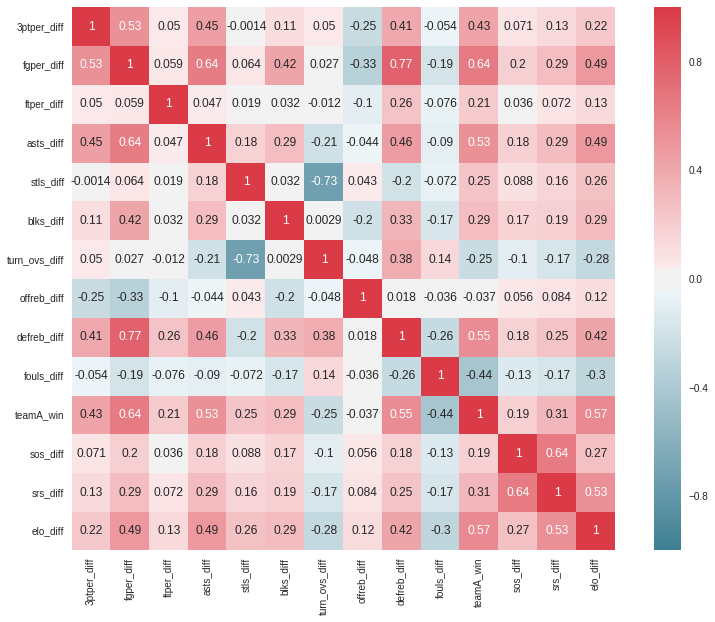

In [41]:
import seaborn as sns

cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff', 'blks_diff', 
        'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff', 'teamA_win', 'sos_diff', 
        'srs_diff', 'elo_diff']

f, ax = plt.subplots(figsize=(14, 10))
corr = final_df[cols].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.tight_layout
plt.show()

In [42]:
reg_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76636 entries, 0 to 76635
Data columns (total 35 columns):
Season     76636 non-null int64
Daynum     76636 non-null int64
Wteam      76636 non-null int64
Wscore     76636 non-null int64
Lteam      76636 non-null int64
Lscore     76636 non-null int64
Wloc       76636 non-null object
Numot      76636 non-null int64
Wfgm       76636 non-null int64
Wfga       76636 non-null int64
Wfgm3      76636 non-null int64
Wfga3      76636 non-null int64
Wftm       76636 non-null int64
Wfta       76636 non-null int64
Wor        76636 non-null int64
Wdr        76636 non-null int64
Wast       76636 non-null int64
Wto        76636 non-null int64
Wstl       76636 non-null int64
Wblk       76636 non-null int64
Wpf        76636 non-null int64
Lfgm       76636 non-null int64
Lfga       76636 non-null int64
Lfgm3      76636 non-null int64
Lfga3      76636 non-null int64
Lftm       76636 non-null int64
Lfta       76636 non-null int64
Lor        76636 non-null 

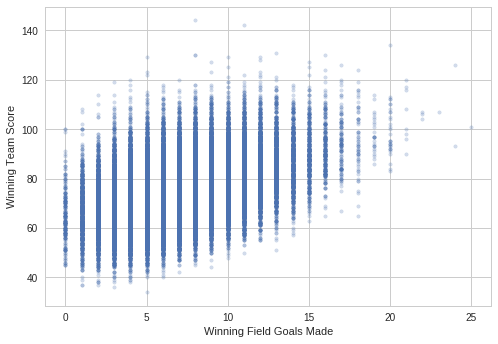

In [43]:
#reg_season['W']

plt.scatter(x=reg_season['Wfgm3'], y=reg_season['Wscore'], marker='.', alpha=0.25)
plt.xlabel('Winning Field Goals Made')
plt.ylabel('Winning Team Score')
ax = plt.gca()
plt.show()

In [44]:
def createTrainingSet(df, year):
    df_train = df[df['season'] != year] #remove one year to test on later
    feat_cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff',
                 'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
                 'sos_diff' , 'srs_diff', 'elo_diff']
    
    X_train = df_train[feat_cols]
    y_train = df_train['teamA_win']

    return X_train, y_train

In [45]:
def createTestSet(df, year):
    df_test = df[df['season'] == year]
    feat_cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff',
                 'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
                 'sos_diff', 'srs_diff', 'elo_diff']
    
    X_test = df_test[feat_cols]
    y_test = df_test['teamA_win']

    return X_test, y_test

In [46]:
year = 2016  #season to test
X_train, y_train = createTrainingSet(final_df, year)
X_test, y_test = createTestSet(final_df, year)

In [47]:
feat_cols = ['3ptper_diff', 'fgper_diff', 'ftper_diff', 'asts_diff', 'stls_diff',
             'blks_diff', 'turn_ovs_diff', 'offreb_diff', 'defreb_diff', 'fouls_diff',
             'sos_diff', 'srs_diff', 'elo_diff']

X = final_df[feat_cols]
y = final_df['teamA_win']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.25)

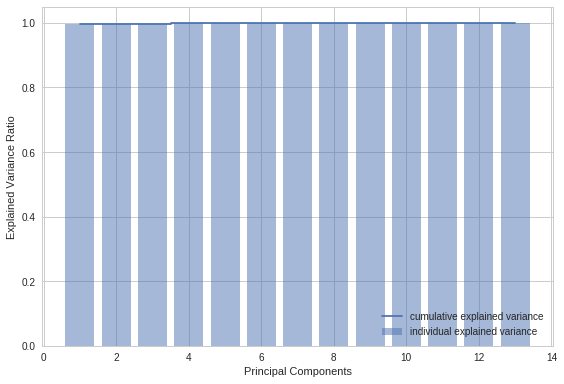

In [48]:
pca = PCA()

pca.fit(X_train)
exp_var = pca.explained_variance_ratio_
exp_var_sum = np.cumsum(exp_var)

#plot explained variance ratio
plt.bar(range(1, len(exp_var) + 1), exp_var_sum, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, len(exp_var) + 1), exp_var_sum, where='mid', label='cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [49]:
#get reduced dataset
pca_n = PCA(n_components = 7)
X_train_pca = pca_n.fit_transform(X_train)
X_test_pca = pca_n.transform(X_test)

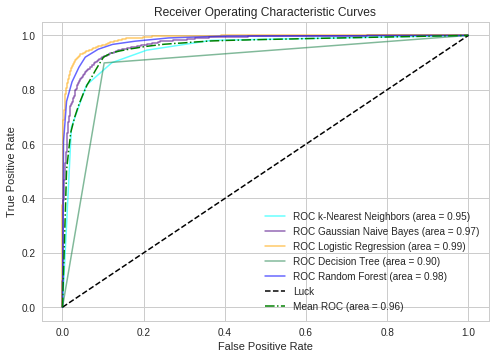

In [50]:
cv = StratifiedKFold(n_splits=10)
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
}

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'orange', 'seagreen', 'blue', 'salmon', 'darkorange'])
lw=1.5  #line width
i = 0
for (name, model), color in zip(models.items(), colors):
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, alpha=0.6,
             label='ROC %s (area = %0.2f)' % (name, roc_auc))

    i += 1
        
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= i
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='-.',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend(loc="lower right")

plt.tight_layout
#plt.savefig('figures/ROC.png', bbox_inches='tight', dpi=300)

plt.show()

In [51]:
def prec_recal_score(model, f, l):
    cross_val_score(model, f, l, cv=10, scoring = 'accuracy')
    y_train_pred = cross_val_predict(model, f, l, cv=5)
    prec_score = precision_score(l, y_train_pred)
    recal_score = recall_score(l, y_train_pred)    
    
    cm = confusion_matrix(l, y_train_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FP = cm[0][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
        
    print('Model: ', model)
    print('Precision Score: ', prec_score)
    print('Recall Score', recal_score)
    print('Specificity Score: ', TNR, '\n')
    print(classification_report(l, y_train_pred))
    print(confusion_matrix(l, y_train_pred))

In [141]:
X_train.head()

,3ptper_diff,fgper_diff,ftper_diff,asts_diff,stls_diff,blks_diff,turn_ovs_diff,offreb_diff,defreb_diff,fouls_diff,sos_diff,srs_diff,elo_diff
11911,-0.150000,-0.145833,0.072727,-5.0,6.0,1.0,-3.0,0.0,-9.0,-3.0,-13.75,-9.90,-56.0000
74210,0.268571,0.272270,0.117500,5.0,1.0,7.0,0.0,-7.0,13.0,-5.0,0.00,0.00,31.0000
63806,-0.363636,-0.130482,0.036364,-4.0,2.0,-1.0,-5.0,-2.0,-10.0,2.0,-1.28,0.75,39.0000
32188,0.025253,-0.024488,0.100000,1.0,1.0,-4.0,-4.0,6.0,0.0,-5.0,0.00,0.00,182.0000
17718,-0.121569,0.008475,0.068182,5.0,0.0,1.0,-3.0,11.0,5.0,2.0,0.00,0.00,-25.6875


In [52]:
lr = LogisticRegression()

lr.fit(X_train, y_train)

train_acc = lr.score(X_train, y_train)
test_acc = lr.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.946082071918
Test accuracy:  0.942718988283


In [53]:
lr = LogisticRegression()

lr.fit(X_train_pca, y_train)

train_acc = lr.score(X_train_pca, y_train)
test_acc = lr.score(X_test_pca, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.917549995274
Test accuracy:  0.906267435373


In [54]:
cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print(np.mean(cv_scores))

0.946973408655


In [55]:
prec_recal_score(lr, X_train, y_train)

Model:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Precision Score:  0.95923629621
Recall Score 0.929271099385
Specificity Score:  0.963386072655 

             precision    recall  f1-score   support

        0.0       0.94      0.96      0.95     38428
        1.0       0.96      0.93      0.94     35629

avg / total       0.95      0.95      0.95     74057

[[37021  1407]
 [ 2520 33109]]


In [56]:
nb = GaussianNB()
nb.fit(X_train, y_train)

train_acc = nb.score(X_train, y_train)
test_acc = nb.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.913755620671
Test accuracy:  0.909057095034


In [57]:
prec_recal_score(nb, X_train, y_train)

Model:  GaussianNB(priors=None)
Precision Score:  0.922721096302
Recall Score 0.89578713969
Specificity Score:  0.930441344853 

             precision    recall  f1-score   support

        0.0       0.91      0.93      0.92     38428
        1.0       0.92      0.90      0.91     35629

avg / total       0.91      0.91      0.91     74057

[[35755  2673]
 [ 3713 31916]]


In [58]:
dtc = DecisionTreeClassifier(random_state = 42)

dtc.fit(X_train, y_train)

train_acc = dtc.score(X_train, y_train)
test_acc = dtc.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  1.0
Test accuracy:  0.894736842105


In [59]:
prec_recal_score(dtc, X_train, y_train)

Model:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=42, splitter='best')
Precision Score:  0.83545752484
Recall Score 0.901512812596
Specificity Score:  0.835380451754 

             precision    recall  f1-score   support

        0.0       0.90      0.84      0.87     38428
        1.0       0.84      0.90      0.87     35629

avg / total       0.87      0.87      0.87     74057

[[32102  6326]
 [ 3509 32120]]


In [60]:
pd.DataFrame({'feature': X_train.columns, 'importance': dtc.feature_importances_})

,feature,importance
0,3ptper_diff,0.047141
1,fgper_diff,0.478977
2,ftper_diff,0.038425
3,asts_diff,0.019864
4,stls_diff,0.013183
5,blks_diff,0.009705
6,turn_ovs_diff,0.076031
7,offreb_diff,0.033272
8,defreb_diff,0.042339
9,fouls_diff,0.091727


In [61]:
sgd = SGDClassifier()

sgd.fit(X_train, y_train)

train_acc = sgd.score(X_train, y_train)
test_acc = sgd.score(X_test, y_test)

print('Train accuracy: ', train_acc)
print('Test accuracy: ', test_acc)

Train accuracy:  0.80014043237
Test accuracy:  0.788915752278


In [62]:
prec_recal_score(sgd, X_train, y_train)

Model:  SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Precision Score:  0.916890611298
Recall Score 0.909736450644
Specificity Score:  0.923545331529 

             precision    recall  f1-score   support

        0.0       0.92      0.92      0.92     38428
        1.0       0.92      0.91      0.91     35629

avg / total       0.92      0.92      0.92     74057

[[35490  2938]
 [ 3216 32413]]


In [63]:
lr.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [64]:
lr = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}


grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
#clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
#GridSearchCV(cv=None,
##             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
 #              dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
 #            param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})


start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
print('best params: ', grid_search.best_params_)
print('best estimator: ', grid_search.best_estimator_)

GridSearchCV took 197.18 seconds for 28 candidate parameter settings.
best params:  {'C': 100, 'solver': 'newton-cg'}
best estimator:  LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)


In [134]:
accuracy = []
lr = LogisticRegression(C=100, solver='newton-cg')
model = lr

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)
    results = model.fit(X_train, y_train)
    preds = model.predict(X_test)

    preds[preds < .5] = 0
    preds[preds >= .5] = 1
    accuracy.append(np.mean(preds == y_test))
    #accuracy.append(np.mean(predictions == Y_test))
    print('Finished iteration: ', i)
print('The accuracy is', sum(accuracy)/len(accuracy))

Finished iteration:  0
Finished iteration:  1
Finished iteration:  2
Finished iteration:  3
Finished iteration:  4
The accuracy is 0.955610849149


In [135]:
model.coef_

array([[  1.11738235e+01,   4.41327222e+01,   8.25670263e+00,
          9.72041184e-02,   3.88413670e-02,   6.10068887e-02,
         -6.32806743e-01,   3.46966362e-01,   2.28795303e-01,
         -2.60913818e-01,  -6.93960776e-02,  -4.25011658e-02,
          5.88094765e-03]])

In [136]:
np.exp(model.coef_)

array([[  7.12409784e+04,   1.46756627e+19,   3.85336714e+03,
          1.10208531e+00,   1.03960555e+00,   1.06290624e+00,
          5.31099048e-01,   1.41476913e+00,   1.25708469e+00,
          7.70347307e-01,   9.32957084e-01,   9.58389348e-01,
          1.00589827e+00]])

In [137]:
model.intercept_

array([-0.52027631])

In [140]:
import plotly.plotly as py
import plotly.graph_objs as go

from sklearn import linear_model

import pylab
from scipy.optimize import curve_fit

In [202]:
y_pred = model.predict_proba(X_train)
y_pred = pd.DataFrame(y_pred[:,1])
y_pred = np.array(y_pred[0])

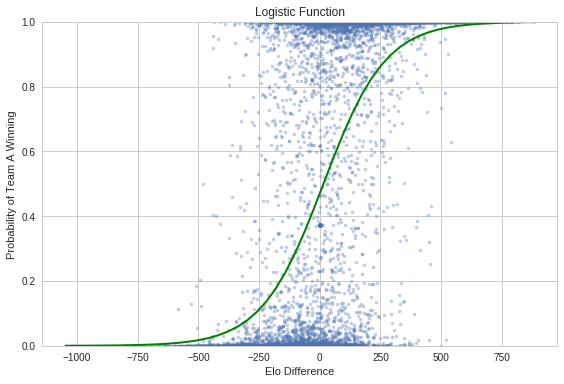

In [230]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

xdata = X_train['elo_diff']
ydata = y_pred

popt, pcov = curve_fit(sigmoid, xdata, ydata)

x = np.linspace(xdata.min(), xdata.max())
y = sigmoid(x, *popt)

pylab.plot(figsize=(18, 12))
pylab.plot(xdata, ydata, '.', alpha=0.35)
pylab.plot(x, y, 'g-', linewidth=2)
pylab.ylim(0, 1)
pylab.xlabel('Elo Difference')
pylab.ylabel('Probability of Team A Winning')
pylab.title('Logistic Function')
pylab.tight_layout()
pylab.show()

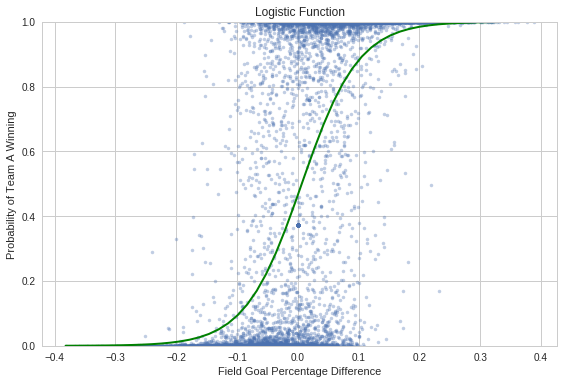

In [231]:
def sigmoid(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

xdata = X_train['fgper_diff']
ydata = y_pred

popt, pcov = curve_fit(sigmoid, xdata, ydata)

x = np.linspace(xdata.min(), xdata.max())
y = sigmoid(x, *popt)

pylab.plot(figsize=(18, 12))
pylab.plot(xdata, ydata, '.', alpha=0.35)
pylab.plot(x, y, 'g-', linewidth=2)
pylab.ylim(0, 1)
pylab.xlabel('Field Goal Percentage Difference')
pylab.ylabel('Probability of Team A Winning')
pylab.title('Logistic Function')
pylab.tight_layout()
pylab.show()

In [79]:
team_stats_df = pd.merge(left=team_stats_df, right=elo_table[['season', 'Team_Id', 'elo']], left_on=['season', 'Team_Id'], 
                         right_on=['season', 'Team_Id'], how='outer')

In [80]:
team_stats_df.head(10)

,season,sos,srs,school,Team_Id,Team_Name,elo
0,1996,5.04,-5.63,Air Force,1102,Air Force,NaN
1,1997,1.15,-4.94,Air Force,1102,Air Force,NaN
2,1998,2.59,-5.51,Air Force,1102,Air Force,NaN
3,1999,2.53,-4.00,Air Force,1102,Air Force,NaN
4,2000,2.58,-5.07,Air Force,1102,Air Force,NaN
5,2001,1.99,-3.57,Air Force,1102,Air Force,NaN
6,2002,3.23,-0.95,Air Force,1102,Air Force,NaN
7,2003,1.46,1.71,Air Force,1102,Air Force,1270.0
8,2004,0.08,9.12,Air Force,1102,Air Force,1516.0
9,2005,2.61,8.61,Air Force,1102,Air Force,1398.0


In [82]:
Wteam_stats = team_stats_df.copy()
Wteam_stats.rename(columns={'Team_Id': 'Wteam', 'sos': 'W_sos', 'srs': 'W_srs', 'elo': 'W_elo'}, inplace=True)
Wteam_stats = Wteam_stats[['season', 'W_sos', 'W_srs', 'W_elo', 'Wteam']]
Wteam_stats.head(10)

,season,W_sos,W_srs,W_elo,Wteam
0,1996,5.04,-5.63,NaN,1102
1,1997,1.15,-4.94,NaN,1102
2,1998,2.59,-5.51,NaN,1102
3,1999,2.53,-4.00,NaN,1102
4,2000,2.58,-5.07,NaN,1102
5,2001,1.99,-3.57,NaN,1102
6,2002,3.23,-0.95,NaN,1102
7,2003,1.46,1.71,1270.0,1102
8,2004,0.08,9.12,1516.0,1102
9,2005,2.61,8.61,1398.0,1102


In [83]:
Lteam_stats = team_stats_df.copy()
Lteam_stats.rename(columns={'Team_Id': 'Lteam', 'sos': 'L_sos', 'srs': 'L_srs', 'elo': 'L_elo'}, inplace=True)
Lteam_stats = Lteam_stats[['season', 'L_sos', 'L_srs', 'L_elo', 'Lteam']]

In [84]:
Wschool_names = teams.copy()
Wschool_names.rename(columns={'Team_Id': 'Wteam', 'Team_Name': 'Win_school'}, inplace=True)
Wschool_names.head()

,Wteam,Win_school
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [85]:
Lschool_names = teams.copy()
Lschool_names.rename(columns={'Team_Id': 'Lteam', 'Team_Name': 'Lose_school'}, inplace=True)
Lschool_names.head()

,Lteam,Lose_school
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [86]:
season_df2 = reg_season.copy()
season_df2.rename(columns={'Season': 'season'}, inplace=True)

In [87]:
#bring in school names for winning team from kaggle team data set
season_df2 = pd.merge(left=season_df2, right=Wschool_names, 
                         left_on=['Wteam'], right_on=['Wteam'], how='outer')

In [88]:
#bring in school names for losing team from kaggle team data set
season_df2 = pd.merge(left=season_df2, right=Lschool_names, 
                         left_on=['Lteam'], right_on=['Lteam'], how='outer')

In [89]:
season_df2.head()

,season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lor,Ldr,Last,Lto,Lstl,Lblk,Lpf,game_id,Win_school,Lose_school
0,2003.0,10.0,1104.0,68.0,1328.0,62.0,N,0.0,27.0,58.0,...,10.0,22.0,8.0,18.0,9.0,2.0,20.0,2003_1104_1328_10,Alabama,Oklahoma
1,2007.0,63.0,1104.0,70.0,1328.0,55.0,H,0.0,22.0,48.0,...,22.0,18.0,12.0,15.0,7.0,2.0,18.0,2007_1104_1328_63,Alabama,Oklahoma
2,2007.0,21.0,1272.0,77.0,1328.0,65.0,N,0.0,25.0,51.0,...,11.0,22.0,8.0,21.0,3.0,5.0,29.0,2007_1272_1328_21,Memphis,Oklahoma
3,2008.0,10.0,1272.0,63.0,1328.0,53.0,N,0.0,22.0,57.0,...,8.0,28.0,12.0,19.0,9.0,1.0,21.0,2008_1272_1328_10,Memphis,Oklahoma
4,2017.0,47.0,1272.0,99.0,1328.0,94.0,A,1.0,33.0,58.0,...,15.0,19.0,12.0,10.0,7.0,3.0,22.0,2017_1272_1328_47,Memphis,Oklahoma


In [90]:
season_df2.dropna(inplace=True)
season_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76636 entries, 0 to 76635
Data columns (total 37 columns):
season         76636 non-null float64
Daynum         76636 non-null float64
Wteam          76636 non-null float64
Wscore         76636 non-null float64
Lteam          76636 non-null float64
Lscore         76636 non-null float64
Wloc           76636 non-null object
Numot          76636 non-null float64
Wfgm           76636 non-null float64
Wfga           76636 non-null float64
Wfgm3          76636 non-null float64
Wfga3          76636 non-null float64
Wftm           76636 non-null float64
Wfta           76636 non-null float64
Wor            76636 non-null float64
Wdr            76636 non-null float64
Wast           76636 non-null float64
Wto            76636 non-null float64
Wstl           76636 non-null float64
Wblk           76636 non-null float64
Wpf            76636 non-null float64
Lfgm           76636 non-null float64
Lfga           76636 non-null float64
Lfgm3          766

In [91]:
season_df2 = pd.merge(left=season_df2, right=Wteam_stats,
                      left_on=['season', 'Wteam'], right_on=['season', 'Wteam'], how='outer')

In [92]:
season_df2.replace(np.nan, 0, inplace=True)

In [93]:
season_df2 = pd.merge(left=season_df2, right=Lteam_stats,
                      left_on=['season', 'Lteam'], right_on=['season', 'Lteam'], how='outer')

In [94]:
season_df2.replace(np.nan, 0, inplace=True)

In [95]:
season_df2.head()

,season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lpf,game_id,Win_school,Lose_school,W_sos,W_srs,W_elo,L_sos,L_srs,L_elo
0,2003.0,10.0,1104.0,68.0,1328.0,62.0,N,0.0,27.0,58.0,...,20.0,2003_1104_1328_10,Alabama,Oklahoma,9.40,13.36,1413.0,8.53,18.86,1626.0
1,2003.0,98.0,1400.0,67.0,1328.0,61.0,H,0.0,25.0,64.0,...,20.0,2003_1400_1328_98,Texas,Oklahoma,9.27,18.91,1588.0,8.53,18.86,1626.0
2,2003.0,124.0,1400.0,76.0,1328.0,71.0,A,0.0,27.0,50.0,...,23.0,2003_1400_1328_124,Texas,Oklahoma,9.27,18.91,1588.0,8.53,18.86,1626.0
3,2003.0,114.0,1281.0,67.0,1328.0,52.0,H,0.0,24.0,55.0,...,17.0,2003_1281_1328_114,Missouri,Oklahoma,10.15,14.87,1516.0,8.53,18.86,1626.0
4,2003.0,70.0,1329.0,48.0,1328.0,46.0,H,0.0,19.0,49.0,...,18.0,2003_1329_1328_70,Oklahoma St,Oklahoma,0.00,0.00,1472.0,8.53,18.86,1626.0


In [96]:
#df.a = df.a.astype(float)
season_df2.season = season_df2.season.astype(int)
season_df2.Daynum = season_df2.Daynum.astype(int)
season_df2.Wteam = season_df2.Wteam.astype(int)
season_df2.Wscore = season_df2.Wscore.astype(int)
season_df2.Lteam = season_df2.Lteam.astype(int)
season_df2.Lscore = season_df2.Lscore.astype(int)

In [97]:
season_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79441 entries, 0 to 79440
Data columns (total 43 columns):
season         79441 non-null int64
Daynum         79441 non-null int64
Wteam          79441 non-null int64
Wscore         79441 non-null int64
Lteam          79441 non-null int64
Lscore         79441 non-null int64
Wloc           79441 non-null object
Numot          79441 non-null float64
Wfgm           79441 non-null float64
Wfga           79441 non-null float64
Wfgm3          79441 non-null float64
Wfga3          79441 non-null float64
Wftm           79441 non-null float64
Wfta           79441 non-null float64
Wor            79441 non-null float64
Wdr            79441 non-null float64
Wast           79441 non-null float64
Wto            79441 non-null float64
Wstl           79441 non-null float64
Wblk           79441 non-null float64
Wpf            79441 non-null float64
Lfgm           79441 non-null float64
Lfga           79441 non-null float64
Lfgm3          79441 non-null 

In [98]:
def getGame_Count(team_id, season_yr):
    data_season = season_df2[(season_df2['season'] == season_yr)]  #create dataframe for just season in question
    games_won = data_season[data_season['Wteam'] == team_id]   #df of games won by season & team
    games_lost = data_season[data_season['Lteam'] == team_id]   #df of games lost by season & team
    all_games = games_won.append(games_lost)
    return all_games.season.count()

In [99]:
getGame_Count(1242, 2017)

32

In [100]:
def getTeam_Name(team_id):
    try:
        name = teams[teams['Team_Id'] == team_id].Team_Name.values[0]
    except:
        name = 'No Team Name'
    return name

In [101]:
def getTeam_ID(team_name):
    try:
        teamid = teams[teams['Team_Name'] == team_name].Team_Id.values[0]
    except:
        teamid = 'No Team Id'
    return teamid

In [102]:
getTeam_Name(1242)

'Kansas'

In [103]:
def getSeason_Data(team_id, season_yr):
    data_season = season_df2[(season_df2['season'] == season_yr)]  #create dataframe for just season in question
    games_won = data_season[data_season['Wteam'] == team_id]   #df of games won by season & team
    games_lost = data_season[data_season['Lteam'] == team_id]   #df of games lost by season & team
    all_games = games_won.append(games_lost)
    
    num_games = len(all_games.index)
    
    team_name = getTeam_Name(team_id)
    test = season_df2[(season_df2['Wteam'] == team_id) & (season_df2['season'] == season_yr)].head(1)
    
    if (team_name == 'No Team Name' or len(test) == 0):
        season_3ptper = 0    
        season_fgper = 0
        season_ftper = 0
        season_asts_pg = 0
        season_stls_pg = 0
        season_blks_pg = 0
        season_tos_pg = 0
        season_offreb_pg = 0
        season_defreb_pg = 0
        season_pf_pg = 0
        season_sos = 0
        season_srs = 0
        season_elo = 0
    else:
        total_fgm = games_won.Wfgm.sum() + games_lost.Lfgm.sum()
        total_fga = games_won.Wfga.sum() + games_lost.Lfga.sum()
        season_fgper = total_fgm / total_fga

        total_3ptm = games_won.Wfgm3.sum() + games_lost.Lfgm3.sum()
        total_3pta = games_won.Wfga3.sum() + games_lost.Lfga3.sum()
        season_3ptper = total_3ptm / total_3pta

        total_ftm = games_won.Wftm.sum() + games_lost.Lftm.sum()
        total_fta = games_won.Wfta.sum() + games_lost.Lfta.sum()
        season_ftper = total_ftm / total_fta

        total_offreb = games_won.Wor.sum() + games_lost.Lor.sum()
        season_offreb_pg = total_offreb / num_games

        total_defreb = games_won.Wdr.sum() + games_lost.Ldr.sum()
        season_defreb_pg = total_defreb / num_games

        total_asts = games_won.Wast.sum() + games_lost.Last.sum()
        season_asts_pg = total_asts / num_games

        total_tos = games_won.Wto.sum() + games_lost.Lto.sum()
        season_tos_pg = total_tos / num_games

        total_blks = games_won.Wblk.sum() + games_lost.Lblk.sum()
        season_blks_pg = total_blks / num_games

        total_stls = games_won.Wstl.sum() + games_lost.Lstl.sum()
        season_stls_pg = total_stls / num_games

        total_pfs = games_won.Wpf.sum() + games_lost.Lpf.sum()
        season_pf_pg = total_pfs / num_games
        
        season_sos = max(games_won.W_sos.mean(), games_lost.L_sos.mean())
        
        season_srs = max(games_won.W_srs.mean(), games_lost.L_srs.mean())
        
        season_elo = max(games_won.W_elo.mean(), games_lost.L_elo.mean())
        
    return [season_3ptper, season_fgper, season_ftper, season_asts_pg, season_stls_pg,
            season_blks_pg, season_tos_pg, season_offreb_pg, season_defreb_pg, season_pf_pg,
            season_sos, season_srs, season_elo]  

In [104]:
def getSeason_Record(team_id, season_yr):
    data_season = season_df2[(season_df2['season'] == season_yr)]  #create dataframe for just season in question
    games_won = data_season[data_season['Wteam'] == team_id]   #df of games won by season & team
    games_lost = data_season[data_season['Lteam'] == team_id]   #df of games lost by season & team
    all_games = games_won.append(games_lost)
    
    num_games = len(all_games.index)
    
    team_name = getTeam_Name(team_id)
    test = season_df2[(season_df2['Wteam'] == team_id) & (season_df2['season'] == season_yr)].head(1)
    
    wins = len(games_won.index)
    losses = len(games_lost.index)
       
    return 'Season ' + str(season_yr) + ' record: ' + str(wins) + ' - ' + str(losses)

In [105]:
def getSeason_Games(team_id, season_yr):
    data_season = season_df2[(season_df2['season'] == season_yr)]  #create dataframe for just season in question
    games_won = data_season[data_season['Wteam'] == team_id]   #df of games won by season & team
    games_lost = data_season[data_season['Lteam'] == team_id]   #df of games lost by season & team
    all_games = games_won.append(games_lost)
    
    num_games = len(all_games.index)
    
    team_name = getTeam_Name(team_id)
    test = season_df2[(season_df2['Wteam'] == team_id) & (season_df2['season'] == season_yr)].head(1)
    
    wins = len(games_won.index)
    losses = len(games_lost.index)
       
    return all_games.sort_values(by=['Daynum'])

In [106]:
team = 'Kansas'

print(team)
print(getSeason_Record(getTeam_ID(team), 2016))
getSeason_Games(getTeam_ID(team), 2016)

Kansas
Season 2016 record: 29 - 4


,season,Daynum,Wteam,Wscore,Lteam,Lscore,Wloc,Numot,Wfgm,Wfga,...,Lpf,game_id,Win_school,Lose_school,W_sos,W_srs,W_elo,L_sos,L_srs,L_elo
7631,2016,11,1242,109,1294,72,H,0.0,34.0,61.0,...,35.0,2016_1242_1294_11,Kansas,N Colorado,11.22,23.87,1827.0,0.00,0.00,1076.0
15949,2016,15,1277,79,1242,73,N,0.0,28.0,60.0,...,18.0,2016_1277_1242_15,Michigan St,Kansas,0.00,0.00,1752.0,11.22,23.87,1827.0
7577,2016,22,1242,92,1417,73,N,0.0,32.0,59.0,...,18.0,2016_1242_1417_22,Kansas,UCLA,11.22,23.87,1827.0,9.69,10.48,1412.0
4036,2016,23,1242,70,1435,63,N,0.0,25.0,55.0,...,21.0,2016_1242_1435_23,Kansas,Vanderbilt,11.22,23.87,1827.0,8.68,17.20,1500.0
7594,2016,29,1242,94,1259,61,H,0.0,37.0,73.0,...,25.0,2016_1242_1259_29,Kansas,Loyola MD,11.22,23.87,1827.0,0.00,0.00,1099.0
7615,2016,33,1242,75,1217,69,H,0.0,28.0,59.0,...,22.0,2016_1242_1217_33,Kansas,Harvard,11.22,23.87,1827.0,-0.25,-0.96,1289.0
7693,2016,37,1242,92,1221,59,H,0.0,34.0,54.0,...,13.0,2016_1242_1221_37,Kansas,Holy Cross,11.22,23.87,1827.0,-6.11,-11.20,1192.0
7565,2016,40,1242,82,1333,67,N,0.0,30.0,56.0,...,22.0,2016_1242_1333_40,Kansas,Oregon St,11.22,23.87,1827.0,0.00,0.00,1523.0
7682,2016,47,1242,88,1285,46,H,0.0,33.0,58.0,...,19.0,2016_1242_1285_47,Kansas,Montana,11.22,23.87,1827.0,-4.29,-0.72,1338.0
7673,2016,50,1242,70,1361,57,A,0.0,26.0,61.0,...,11.0,2016_1242_1361_50,Kansas,San Diego St,11.22,23.87,1827.0,0.00,0.00,1561.0


In [107]:
getTeam_ID('Kansas')

1242

In [108]:
getTeam_ID('S Dakota St')

1355

In [109]:
team = 'Stony Brook'
getSeason_Data(getTeam_ID(team), 2016)

[0.37524177949709864,
 0.47680995475113125,
 0.6689895470383276,
 16.3,
 5.9,
 4.6,
 11.666666666666666,
 11.833333333333334,
 26.5,
 16.233333333333334,
 -5.28,
 3.75,
 1498.0]

In [110]:
team = 'Kentucky'
getSeason_Data(getTeam_ID(team), 2016)

[0.3704866562009419,
 0.4785608674223756,
 0.6833976833976834,
 14.411764705882353,
 5.617647058823529,
 5.647058823529412,
 11.0,
 12.882352941176471,
 25.705882352941178,
 20.470588235294116,
 8.840000000000002,
 20.230000000000004,
 1675.0]

In [111]:
def Team_Compare(team_A, team_B, year):
    team_1 = getSeason_Data(team_A, year)
    team_2 = getSeason_Data(team_B, year)
    diff = [a - b for a, b in zip(team_1, team_2)]
    return diff

In [112]:
Team_Compare(1242, 1390, 2010)

[0.05540504381563982,
 0.0546889353941018,
 0.037390485613519875,
 4.053308823529413,
 3.0367647058823533,
 4.724264705882353,
 0.8455882352941178,
 2.4099264705882355,
 4.3382352941176485,
 0.733455882352942,
 1.75,
 18.97,
 475.0]

In [113]:
team_list = teams['Team_Name'].tolist()

def MakeSeason_Dict(year):
    season_dict = c.defaultdict(list)
    for team in team_list:
        team_id = teams[teams['Team_Name'] == team].values[0][0]
        team_vector = Season_Data(team_id, year)
        season_dict[team_id] = team_vector
    return season_dict

In [232]:
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(C=100, solver='newton-cg'),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Bernoulli Naive Bayes': BernoulliNB()
}
def predictOutcome_avg(team1, team2, year, X, y):
    diff = Team_Compare(getTeam_ID(team1), getTeam_ID(team2), year)
    outcomes = []
    scores = []
    for k, v in models.items():
        v.fit(X, y)
        scores.append(v.score(X_train, y_train))
        outcomes.append(v.predict_proba(diff)[0,1])
        #outcomes.append((k + ': ' + 'Probability that ' + team1_name + ' beats ' + team2_name + ': ', 
                         #v.predict_proba(diff)[0,1]))
        #outcomes.append(outcome)
    result = (sum(outcomes) / len(outcomes)) * 100
    #stmt = 'Average probability that ' + team1_name + ' beats ' + team2_name + ': ' + result
    return result
    #return model.predict(diff)

In [120]:
def predictOutcome(team1, team2, year, X, y):
    lr = LogisticRegression(C=100, solver='newton-cg')
    model = lr
    diff = Team_Compare(getTeam_ID(team1), getTeam_ID(team2), year)
    model.fit(X, y)
    return lr.predict_proba(diff)[0,1]

In [116]:
getSeason_Data(1463, 2016)

[0.37124463519313305,
 0.46728354263053534,
 0.6666666666666666,
 15.074074074074074,
 5.592592592592593,
 4.518518518518518,
 13.481481481481481,
 13.481481481481481,
 26.814814814814813,
 17.962962962962962,
 -1.03,
 9.080000000000004,
 1516.0]

In [195]:
getTeam_ID('Stephen Austin')

'No Team Id'

In [125]:
year = 2017  #season to remove from training set
X_train, y_train = createTrainingSet(final_df, year)

team1_name = 'Kansas'
team2_name = 'Austin Peay'

answer = str(round(predictOutcome_avg(team1_name, team2_name, year, X_train, y_train), 2))

print('Probability that ' + team1_name + ' beats ' + team2_name + ': ' + answer + '% (season data: ' + str(year) + ')')

Probability that Kansas beats Austin Peay: 98.27% (season data: 2017)


In [126]:
year = 2017  #season to remove from training set 
X_train, y_train = createTrainingSet(final_df, year)

team1_name = 'Kentucky'
team2_name = 'Stony Brook'

answer = str(round(predictOutcome(team1_name, team2_name, year, X_train, y_train) * 100, 2))

print('Probability that ' + team1_name + ' beats ' + team2_name + ': ' + answer + '% (season data: ' + str(year) + ')')

Probability that Kentucky beats Stony Brook: 99.39% (season data: 2017)


In [ ]:
sub = submission.head(10)

In [ ]:
def createPrediction():
    game_id = []
    outcome_prob = []
    sub_df = pd.DataFrame()
    
    for index, row in submission.iterrows():
        id_row = row['Id']
        year = int(id_row[0:4])
        team1_id = int(id_row[5:9])
        team2_id = int(id_row[10:14])

        pred = predictOutcome(team1_id, team2_id, year, X_train, y_train)

        game_id.append(id_row)
        outcome_prob.append(pred[0,0])
    sub_dict = dict(zip(game_id, outcome_prob))

    outfile = open('2016_submission.csv', 'w')
    for key, value in sorted(sub_dict.items()):
        outfile.write( str(key) + ', ' + str(value) + '\n')

In [ ]:
#createPrediction()